**SOW-MKI49: Neural Information Processing Systems**  
*Weeks 2 and 3: Assignment (200 points + 20 bonus points + 1 bonus point for each bug you find and another bonus point if you debug it and before you ask, no, typos unfortunately are not considered bugs - first come, first served)*  
Author: Umut

In [0]:
# Group number: ...
# Student 1 name, student 1 number: ...
# Student 2 name, student 2 number: ...
# Student 3 name, student 3 number: ...

In [107]:
batch_size = 4
data_directory = 'data/' # Make a directory to store the data and enter it here.
                    # We will be using a smaller dataset (LFW) than the one used in the paper (CelebA) for computational resource considerations.
                    # Download it from http://vis-www.cs.umass.edu/lfw/lfw-deepfunneled.tgz.
device = -1
epochs = 100
lambda_ = {'feature': 1., 'pixel': 1., 'total_variation': 1e-5}
model_directory = 'models/' # Make a directory to store the models and enter it here. Move Vgg4Layers.npz to the model directory.
outsize = (96, 96)

**Packages (10 points)**  
In this cell, you will import the required packages.  
*Tasks*   
- (1) It is always good practice to first think about the big picture and not rush into writing code before clearly knowing everything that you will have to do so as to avoid future complications. Therefore, your first task is to study the skeleton code and come up with a plan of how to proceed. (**0 points**)
- (2) However, I agree that doing so is arguably the most boring part of coding, and you rather skip it. To help you to resist the temptation of skipping going through the skeleton code, I have removed the import statements. Your second task is to Identify the required packages and import them. Note that if you are using Python 2.7, you should import print from the future. (**10 points**)

In [108]:
# (2) start
import os
import chainer
from chainer.dataset import DatasetMixin, concat_examples
from chainer import iterators
import chainer.links as L
from chainer import Chain, ChainList
import chainer.functions as F
from chainer.serializers import load_npz
from chainer.optimizers import Adam
import numpy as np
from PIL import Image
import cv2
from glob import glob

# (2) end

**Preprocessing functions (10 points + 5 bonus points)** (taken from https://github.com/mbeyeler/opencv-python-blueprints)  
In the following cell, you will implement some of the preprocessing functions. The rest of the preprocessing steps have already been applied to the data.  
*Tasks*
- (1) Implement the resizing operation. That is, you should extract the data, resize each portrait to 96 pixels x 96 pixels and save them to the data directory as JPG. (**10 points **)
- (2) The pencil sketch class implements the sketch effect in a simpler way than the one mentioned in the lecture. Explain how/why the used operations (blur and divide) convert portraits to sketches, and how it differs from that which was mentioned in the lecture? (**5 bonus points**)

In [109]:
# (1) start

# TODO: Uncomment this
# base_path = os.getcwd()
# raw_dir = os.path.join(base_path, 'lfw-deepfunneled')
# for actor in os.listdir(raw_dir):
#     for img_name in os.listdir(os.path.join(raw_dir, actor)):
#         img = Image.open(os.path.join(raw_dir, actor, img_name))
#         img_small = img.resize(outsize)
#         img_small.save(os.path.join(data_directory, img_name))
# (1) end

class PencilSketch:
    """Pencil sketch effect
        A class that applies a pencil sketch effect to an image.
    """

    def __init__(self, dimension):
        """Initialize parameters
            :param (width, height): Image size.
        """
        self.width, self.height = dimension

        # try to open background canvas (if it exists)

# TODO: Remove next 3 lines if not used later
#         self.canvas = cv2.imread(bg_gray, cv2.CV_8UC1)
#         if self.canvas is not None:
#             self.canvas = cv2.resize(self.canvas, (self.width, self.height))

    def render(self, img_rgb):
        """Applies pencil sketch effect to an RGB image
            :param img_rgb: RGB image to be processed
            :returns: Processed RGB image
        """
        img_gray = cv2.cvtColor(img_rgb, cv2.COLOR_RGB2GRAY)
        img_blur = cv2.GaussianBlur(img_gray, (21, 21), 0, 0)
        img_blend = cv2.divide(img_gray, img_blur, scale=256)

        # return cv2.cvtColor(img_blend, cv2.COLOR_GRAY2RGB)
        return img_blend

def pencil_sketch(img_rgb):
    pencilSketch = PencilSketch((img_rgb.shape[1], img_rgb.shape[0]))

    return pencilSketch.render(img_rgb)

# Ans: In the lecture we make sketches using edge detection #TODO

def preprocess(img):
    if img.mode == 'L':
        return np.rollaxis(np.asarray(img, 'float32')[..., None], 2)
    else:
        return np.rollaxis(np.asarray(img, 'float32')[..., ::-1], 2)

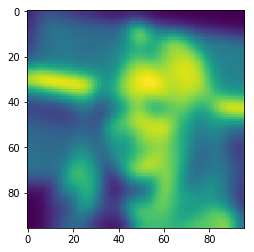

In [132]:
from matplotlib.pyplot import imshow
%matplotlib inline

img = np.asarray(Image.open('data/AJ_Cook_0001.jpg').convert('RGB').resize((96,96), Image.LANCZOS), 'f')
imshow(cv2.GaussianBlur(cv2.cvtColor(img, cv2.COLOR_RGB2GRAY), (21, 21), 0, 0))

**Data class**  
The following cell defines the data class. It is used to manage the data (loading, etc.). *You do not have to make any changes to the code.*  
*Task*
- (1) Study the code and refer to the chainer docuimentation if anything is unclear. You will be expected to write similar code by yourself in the coming practicals. (**0 points**)

In [110]:
class Dataset(DatasetMixin):
    def __init__(self, data_files):
        self.data_files = data_files

    def __len__(self):
        return len(self.data_files)

    def get_example(self, i):
        t = np.asarray(Image.open(self.data_files[i]).convert('RGB').resize((96, 96), Image.LANCZOS), 'f').transpose(2, 0, 1)
        x = pencil_sketch(np.asarray(Image.open(self.data_files[i]).convert('RGB').resize((96, 96), Image.LANCZOS), 'f'))[None]

        return t, x

**Model classes (45 points)**  
In the following cellyou will implement the model classes.
*Tasks*   
- (1) Implement the layers of the model by filling in the missing code. (**20 points**)
- (2) Reimplement the model as a ChainList instead of a Chain. (**5 points**)
- (3) Implement the forward pass of the residual block by filling in the missing code. (**20 points**)

In [111]:
class Model(Chain):
    def __init__(self, in_channels, outsize):
        super(Model, self).__init__()

        with self.init_scope():
            # (1) start
            self.convolution2D_0 = L.Convolution2D(in_channels=in_channels, out_channels=32, ksize=9,
                                              stride=1, pad=4)
            self.batchNormalization_0 = L.BatchNormalization(size=32)
            self.convolution2D_1 = L.Convolution2D(in_channels=32, out_channels=64, ksize=3,
                                              stride=2, pad=1)
            self.batchNormalization_1 = L.BatchNormalization(size=64)
            self.convolution2D_2 = L.Convolution2D(in_channels=64, out_channels=128, ksize=3,
                                              stride=2, pad=1)
            self.batchNormalization_2 = L.BatchNormalization(size=128)
            self.residualBlock_3 = ResidualBlock(128, 128)
            self.residualBlock_4 = ResidualBlock(128, 128)
            self.residualBlock_5 = ResidualBlock(128, 128)
            self.residualBlock_6 = ResidualBlock(128, 128)
            self.residualBlock_7 = ResidualBlock(128, 128)
            self.deconvolution2D_8 = L.Deconvolution2D(in_channels=128, out_channels=64, ksize=3,
                                                  stride=2, pad=1)
            self.batchNormalization_8 = L.BatchNormalization(size=64)
            # (1) end
            self.deconvolution2D_9 = L.Deconvolution2D(64, 32, 3, 2, 1, True, outsize)
            self.batchNormalization_9 = L.BatchNormalization(32)
            self.convolution2D_10 = L.Convolution2D(32, 3, 9, pad = 4, nobias = True)
            self.batchNormalization_10 = L.BatchNormalization(3)

        self.in_channels = in_channels
        self.outsize = outsize

    def __call__(self, x, finetune = False):
        import pdb; pdb.set_trace()
        h = self.convolution2D_0(x)
        h = self.batchNormalization_0(h)
        h = F.relu(h)
        h = self.convolution2D_1(h)
        h = self.batchNormalization_1(h, finetune)
        h = F.relu(h)
        h = self.convolution2D_2(h)
        h = self.batchNormalization_2(h, finetune)
        h = F.relu(h)
        h = self.residualBlock_3(h, finetune)
        h = self.residualBlock_4(h, finetune)
        h = self.residualBlock_5(h, finetune)
        h = self.residualBlock_6(h, finetune)
        h = self.residualBlock_7(h, finetune)
        h = self.deconvolution2D_8(h)
        h = self.batchNormalization_8(h, finetune)
        h = F.relu(h)
        h = self.deconvolution2D_9(h)
        h = self.batchNormalization_9(h, finetune)
        h = F.relu(h)
        h = self.convolution2D_10(h)
        h = self.batchNormalization_10(h, finetune)
        y = 127.5 * F.tanh(h) + 127.5

        return y

# TODO: Uncomment below and add a __call__ method
# class Model(ChainList):
#     # (2) start
#     def __init__(self, in_channels, outsize):
#         super(Model, self).__init__()
        
#         self.in_channels = in_channels
#         self.outsize = outsize
        
#         with self.init_scope():
#             hidden_layers = [
#                 L.Convolution2D(in_channels=3, out_channels=32, ksize=9,
#                                                  stride=1, pad=4),
#                 L.BatchNormalization(size=32),
#                 L.Convolution2D(in_channels=32, out_channels=64, ksize=3,
#                                               stride=2, pad=1),
#                 L.BatchNormalization(size=64),
#                 L.Convolution2D(in_channels=64, out_channels=128, ksize=3,
#                                               stride=2, pad=1),
#                 L.BatchNormalization(size=128)]
            
#             for n_residuals in range(5):
#                 hidden_layers.append(ResidualBlock(128, 128))
            
#             hidden_layers.extend([
#                 L.Deconvolution2D(in_channels=128, out_channels=64, ksize=3,
#                                                   stride=2, pad=1),
#                 L.BatchNormalization(size=64),
#                 L.Deconvolution2D(64, 32, 3, 2, 1, True, outsize),
#                 L.BatchNormalization(32),
#                 L.Convolution2D(32, 3, 9, pad = 4, nobias = True),
#                 L.BatchNormalization(3)
#             ])
#         self.hidden_layers = ChainList(*hidden_layers)
    
#     def __call__(self)
#     # (2) end


class ResidualBlock(Chain):
    def __init__(self, in_channels, out_channels):
        super(ResidualBlock, self).__init__()

        with self.init_scope():
            batchNormalization_0 = L.BatchNormalization(out_channels)
            batchNormalization_1 = L.BatchNormalization(out_channels)
            convolution2D_0 = L.Convolution2D( in_channels, out_channels, 3, pad = 1, nobias = True)
            convolution2D_1 = L.Convolution2D(out_channels, out_channels, 3, pad = 1, nobias = True)

        self.in_channels = in_channels
        self.out_channels = out_channels

    def __call__(self, x, finetune = False):
        # (3) start
        h = self.convolution2D_0(x)
        h = self.batchNormalization_0(h, finetune)
        h = F.relu(h)
        h = self.convolution2D_0(h)
        h = self.batchNormalization_1(h, finetune)
        # TODO: Check this relu if things don't work.
        y = F.relu(h + x)
        # (3) start

        return y

**Loss classes (45 points)**  
In the following cell, you will implement the loss classes.  
*Tasks*  
- (1) You are provided with a custom VGG-16 implementation. How does it differ than the original implementation? Why can we get away with using the simpler implementation? (**5 points**)
- (2) Implement the missing convolution layer of the total variation loss by filling in the missing code. (**10 points**)
- (3) Implement the forward pass of the total variation loss by filling in the missing code. (**10 points**)
- (4) Implement the feature loss component in the forward pass of the loss function by filling in the missing code. (**10 points**)
- (5) Explain why the loss components are scaled. (**5 points**)
- (6) Explain why the target features are extracted in test mode. (**5 points**)

In [112]:
class Vgg4Layers(Chain):
    def __init__(self):
        super(Vgg4Layers, self).__init__()

        with self.init_scope():
            self.conv1_1 = L.Convolution2D(  3,  64, 3, pad = 1)
            self.conv1_2 = L.Convolution2D( 64,  64, 3, pad = 1)
            self.conv2_1 = L.Convolution2D( 64, 128, 3, pad = 1)
            self.conv2_2 = L.Convolution2D(128, 128, 3, pad = 1)

        self.add_persistent('mean', np.array([[[[103.939]], [[116.779]], [[123.68]]]], 'float32'))

    def __call__(self, x):
        h = x - F.broadcast_to(self.mean, x.shape)
        h = self.convolution2D_0(h)
        h = F.relu(h)
        h = self.convolution2D_1(h)
        h = F.relu(h)
        h = F.max_pooling_2d(h, 2, 2)
        h = self.convolution2D_2(h)
        h = F.relu(h)
        h = self.convolution2D_3(h)
        y = F.relu(h)

        return y

class TotalVariationLoss(Chain):
    def __init__(self):
        super(TotalVariationLoss, self).__init__()

        with self.init_scope():
            convolution2D_0 = L.Convolution2D(3, 1, 2, nobias = True, initialW = np.array([3 * [[[-1], [1]]]], 'float32'))
            # (2) start
            convolution2D_1 = L.Convolution2D(3, 1, 2, nobias=True, initialW=np.array([3 * [[[-1, 1]]]], 'float32'))
            # (2) end

    def __call__(self, x):
        # (3) start
        # TODO: Check in case of errors
        y = np.sqrt(self.convolution2D_0**2 + self.convolution2D_1**2)
        # (3) end

        return y

class LossFunction(object):
    def __init__(self, lambda_):
        self.totalVariationLoss = TotalVariationLoss()
        self.vgg4Layers         = Vgg4Layers()

        def __call__(t, y):            
            with chainer.using_config('train', False):
                t_ = self.vgg4Layers(t)

            # (4) start
            y_ = self.vgg4Layers(y)
            feature = chainer.functions.mean_squared_error(t_, y_)
            # (4) end
            pixel_loss = lambda_['pixel'] * F.mean_squared_error(t , y)
            total_variation_loss = lambda_['total_variation'] * self.totalVariationLoss(y)
            loss = feature + pixel_loss + total_variation_loss

            return loss

# (1) Write your answer here.
# (5) Write your answer here.
# (6) Write your answer here.

**Initialization (10 points)**  
The following cell initializes the loss function, the loss history, the model, the optimizer, the datasets and the iterators. *You do not have to make any changes to the code.*  
*Tasks*
- (1) Study the code and refer to the chainer docuimentation if anything is unclear. You will be expected to write similar code by yourself in the coming practicals. (**0 points**)  
- (2) What are the boolean arguments that are passed to the SerialIterator class? (**5 points**)  
- (3) Why is it false for the training iterator but not for other iterators? In other words, what would happen if we were to set it to false for the training iterator and true for the other iterators? (**5 points**)

In [113]:
lossFunction = LossFunction(lambda_)
load_npz('{:s}/Vgg4Layers.npz'.format(model_directory), lossFunction.vgg4Layers, strict=False)
loss_history = {'training': [], 'validation': []}
model = Model(1, outsize) if device < 0 else Model(1, outsize).to_gpu(device)
optimizer = Adam()

optimizer.setup(model)

data_file = sorted(glob('{}/*.jpg'.format(data_directory)))
training_set = Dataset(data_file[:int(.64 * len(data_file))])
validation_set = Dataset(data_file[int(.64 * len(data_file)) : int(.8 * len(data_file))])
test_set = Dataset(data_file[int(.8 * len(data_file)): ])
training_iterator = iterators.SerialIterator(training_set, batch_size, False, True)
validation_iterator = iterators.SerialIterator(validation_set, batch_size, False, False)
test_iterator = iterators.SerialIterator(test_set , batch_size, False, False)

# (2) repeat and shuffle are booleans in the SerialIterator. If the boolean for repeat is set to True, 
#     the iterator iterates infinitely over the dataset. If it is set to False, the iterator iterates 
#     only once over the dataset. If the boolean for shuffle is set to True the examples are shuffeled
#     at the beginning of each iteration. If set to False, the examples are iterated through in order 
#     of indexes.
# (3) Write your answer here.

**Training and validation (20 points)**  
In the following cell, you will train and validate your model.
*Tasks*   
- (1) Implement training loss estimation, backprop and parameter update. (**10 points**)
- (2) Implement validation loss history (**5 points**)
- (3) Implement model serialization  (**5 points**)

In [115]:
for i in range(epochs):
    loss_history['training'].append(0)

    for j, batch in enumerate(training_iterator):
        with chainer.using_config('train', True):
            t, x = concat_examples(batch, device)
            y = model(x)
            # (1) start
            # loss = ...
            # ...
            # ...
            # ...
            # (1) end

        loss_history['training'][-1] += float(loss.data)

    loss_history['training'][-1] /= j + 1
    # (2) start
    # ...

    for j, batch in enumerate(validation_iterator):
        with chaine.using_config('train', False):
            t, x = concat_examples(batch, device)
            y = model(x)
            loss = lossFunction(t, y)

        # ...

    # ...
    # (2) end
    print('epoch: {:3d} / {:03d}, training loss: {:.4f}, validation loss: {:.4f}.'.format(i + 1, epochs, log['training'], log['validation']))
    np.savez('{:s}/loss_history_{:03d}.npz'.format(model_directory, epoch), loss_history)
    # (3) start
    # ...
    # (3) end
    save_npz('{:s}/optimizer_{:03d}.npz'.format(model_directory, epoch), optimizer)

> <ipython-input-111-7f21282140af>(35)__call__()
-> h = self.convolution2D_0(x)
(Pdb) l
 30  	        self.in_channels = in_channels
 31  	        self.outsize = outsize
 32  	
 33  	    def __call__(self, x, finetune = False):
 34  	        import pdb; pdb.set_trace()
 35  ->	        h = self.convolution2D_0(x)
 36  	        h = self.batchNormalization_0(h)
 37  	        h = F.relu(h)
 38  	        h = self.convolution2D_1(h)
 39  	        h = self.batchNormalization_1(h, finetune)
 40  	        h = F.relu(h)
(Pdb) n
> <ipython-input-111-7f21282140af>(36)__call__()
-> h = self.batchNormalization_0(h)
(Pdb) n
> <ipython-input-111-7f21282140af>(37)__call__()
-> h = F.relu(h)
(Pdb) n
> <ipython-input-111-7f21282140af>(38)__call__()
-> h = self.convolution2D_1(h)
(Pdb) n
> <ipython-input-111-7f21282140af>(39)__call__()
-> h = self.batchNormalization_1(h, finetune)
(Pdb) n
TypeError: __call__() takes 2 positional arguments but 3 were given
> <ipython-input-111-7f21282140af>(39)__call__()
-

BdbQuit: 

**Test (45 points + 15 bonus points)**  
In the following cell, you will test your model.  
*Tasks*
- (1) Estimate the test loss, print it and save it. (**15 points**)
- (2) Estimate the validation metrics, print them and save them (tip: scikit-image) (**15 bonus points**)
- (3) Plot example results (i.e., plot a few t, x and y) (**10 points**)
- (4) Dicuss your implementation in 300 - 350 words (e.g., how good your results are, how you can improve your model, etc.) (**20 points**)

In [116]:
# (1), (2) and (3) start
# .
# .
# .
# (1), (2) and (3) end

# (4) Write your answer here.

In [117]:
chainer.__version__

'4.4.0'